<a href="https://colab.research.google.com/github/kartikbatra056/AllAboutTimeSeries/blob/main/TimeSeriesWithLSTMandDCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'rohanrao/nifty50-stock-market-data'

 50% 9.00M/18.0M [00:00<00:00, 35.1MB/s]
100% 18.0M/18.0M [00:00<00:00, 51.8MB/s]


In [ ]:
!unzip '/content/nifty50-stock-market-data.zip'

Archive:  /content/nifty50-stock-market-data.zip
  inflating: ADANIPORTS.csv          
  inflating: ASIANPAINT.csv          
  inflating: AXISBANK.csv            
  inflating: BAJAJ-AUTO.csv          
  inflating: BAJAJFINSV.csv          
  inflating: BAJFINANCE.csv          
  inflating: BHARTIARTL.csv          
  inflating: BPCL.csv                
  inflating: BRITANNIA.csv           
  inflating: CIPLA.csv               
  inflating: COALINDIA.csv           
  inflating: DRREDDY.csv             
  inflating: EICHERMOT.csv           
  inflating: GAIL.csv                
  inflating: GRASIM.csv              
  inflating: HCLTECH.csv             
  inflating: HDFC.csv                
  inflating: HDFCBANK.csv            
  inflating: HEROMOTOCO.csv          
  inflating: HINDALCO.csv            
  inflating: HINDUNILVR.csv          
  inflating: ICICIBANK.csv           
  inflating: INDUSINDBK.csv          
  inflating: INFRATEL.csv            
  inflating: INFY.csv                
 

In [190]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')
%matplotlib inline

In [191]:
df=pd.read_csv('/content/RELIANCE.csv',parse_dates=['Date'])
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [192]:
def train_test_data(data):
     '''
     Scale and split dataset.
     parameters:
       data:Time series dataset 
     returns: 
       train_df: Training data
       valid_df: Validation Data
     '''
     
     scaler=MinMaxScaler()
     
     data=data.asfreq('D')

     data.fillna(method='bfill',inplace=True)

     data.fillna(method='ffill',inplace=True)

     train_df=pd.DataFrame(index=data.iloc[:-int(len(data)*0.2)].index)

     valid_df=pd.DataFrame(index=data.iloc[-int(len(data)*0.2):].index)
     
     train_df['VWAP']=scaler.fit_transform(np.reshape(data.iloc[:-int(len(data)*0.2)].values,(-1,1))).squeeze(1)
     
     valid_df['VWAP']=scaler.transform(np.reshape(data.iloc[-int(len(data)*0.2):].values,(-1,1))).squeeze(1)
     
     return train_df,valid_df

In [193]:
class RelianceDataset(Dataset):
      def __init__(self,data,T=10,step=1):
          super().__init__()
          self.data=np.reshape(data.values,(data.shape[0],1))
          self.T=T
          self.chunks=torch.FloatTensor(self.data).unfold(0,self.T,step).permute(0,2,1)
          
      def __getitem__(self,index:int): 
          
           x=self.chunks[index,:-1,:]
           y=self.chunks[index,-1,:]   
           return x,y
      
      def __len__(self):
          
          return self.chunks.size(0)

In [194]:
df.set_index('Date',inplace=True)
train_df,valid_df=train_test_data(df['VWAP'])
train_df.shape,valid_df.shape

((6086, 1), (1521, 1))

In [195]:
train_data=RelianceDataset(train_df)
valid_data=RelianceDataset(valid_df)
train_loader=DataLoader(train_data,batch_size=32)
valid_loader=DataLoader(valid_data,batch_size=32)

In [196]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [243]:
class LSTMModel(nn.Module):
    
    def __init__(self,n_stocks,h_dim,n_layers=1,drop_l=0.05,bidirect=False):
        
        super(LSTMModel,self).__init__() 
        
        if bidirect: 
          self.n_layers=2*n_layers
          n=2
        else:
          self.n_layers=n_layers  
          n=1 
        self.h_dim=h_dim

        self.lstm=nn.LSTM(n_stocks,h_dim,n_layers,batch_first=True,dropout=drop_l,bidirectional=bidirect)

        self.fc=nn.Linear(n*h_dim,n_stocks)

    def forward(self,Input):     
    
        h0,c0=torch.zeros((self.n_layers,Input.size(0),self.h_dim)).to(device),torch.zeros((self.n_layers,Input.size(0),self.h_dim)).to(device)

        output,(h0,c0)=self.lstm(Input,(h0,c0))

        out=self.fc(output[:,-1,:])
        
        return out 

In [277]:
n_stocks=1
h_dim=32
n_layers=1
drop_l=0.0
bidirect=False
model=LSTMModel(n_stocks,h_dim,n_layers,drop_l,bidirect)
model=model.to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [278]:
def valid_model():
  
     with torch.no_grad():
        val_loss=0.0
        val_mae=0.0
        pred_list=[]
        target_list=[]
        model.eval() 
        for x,y in valid_loader:
             
             x=x.to(device)
             y=y.to(device)
             
             pred=model(x)

             loss=criterion(pred,y)

             val_loss+=loss.item()*x.size(0)
             
             target_list.append(y.detach().cpu().numpy())

             pred_list.append(pred.detach().cpu().numpy()) 

        val_loss/=len(valid_data)
         
        predictions=np.concatenate(pred_list,axis=0)

        target=np.concatenate(target_list,axis=0) 
        
        val_mae=mean_absolute_error(target,predictions)

        return val_loss,val_mae

In [279]:
def train_model(num_epochs):
     train_loss_list=[]
     val_loss_list=[]
     for i in range(num_epochs):
        epoch_loss=0.0
        train_mae=0.0
        pred_list=[]
        target_list=[]
        model.train()
        for x,y in train_loader:
             
             x=x.to(device)
             y=y.to(device)
             
             optimizer.zero_grad()

             pred=model(x)

             loss=criterion(pred,y)

             loss.backward()

             optimizer.step()

             epoch_loss+=loss.item()*x.size(0)

             target_list.append(y.detach().cpu().numpy())

             pred_list.append(pred.detach().cpu().numpy())
             
        epoch_loss/=len(train_data)    

        predictions=np.concatenate(pred_list,axis=0)

        target=np.concatenate(target_list,axis=0) 
        
        train_mae=mean_absolute_error(target,predictions)

        val_loss,val_mae=valid_model()
        
        train_loss_list.append(epoch_loss)

        val_loss_list.append(val_loss) 

        print(f'Epoch:{i+1} \n Train loss:{epoch_loss:.3} , Train mae:{train_mae:.3} ,Val loss:{val_loss:.3} , Val mae:{val_mae:.3}')         
     
     print()
     ax=plt.figure(figsize=(15,5))
     plt.plot(range(len(train_loss_list)),train_loss_list,label='Training loss')
     plt.plot(range(len(train_loss_list)),val_loss_list,label='Validation loss')
     plt.title('Training and Validation Loss')
     plt.xlabel('Epoch')
     plt.ylabel('Loss')
     plt.legend()
     plt.show()

Epoch:1 
 Train loss:0.0062 , Train mae:0.0542 ,Val loss:0.0214 , Val mae:0.109
Epoch:2 
 Train loss:0.0203 , Train mae:0.101 ,Val loss:0.0214 , Val mae:0.112
Epoch:3 
 Train loss:0.0211 , Train mae:0.104 ,Val loss:0.0187 , Val mae:0.105
Epoch:4 
 Train loss:0.0168 , Train mae:0.0931 ,Val loss:0.0154 , Val mae:0.0947
Epoch:5 
 Train loss:0.0127 , Train mae:0.0816 ,Val loss:0.0125 , Val mae:0.0851
Epoch:6 
 Train loss:0.00966 , Train mae:0.0711 ,Val loss:0.00951 , Val mae:0.0739
Epoch:7 
 Train loss:0.0068 , Train mae:0.0591 ,Val loss:0.00669 , Val mae:0.0614
Epoch:8 
 Train loss:0.00441 , Train mae:0.047 ,Val loss:0.00452 , Val mae:0.05
Epoch:9 
 Train loss:0.00276 , Train mae:0.0368 ,Val loss:0.00299 , Val mae:0.0405
Epoch:10 
 Train loss:0.00171 , Train mae:0.0289 ,Val loss:0.00196 , Val mae:0.0328



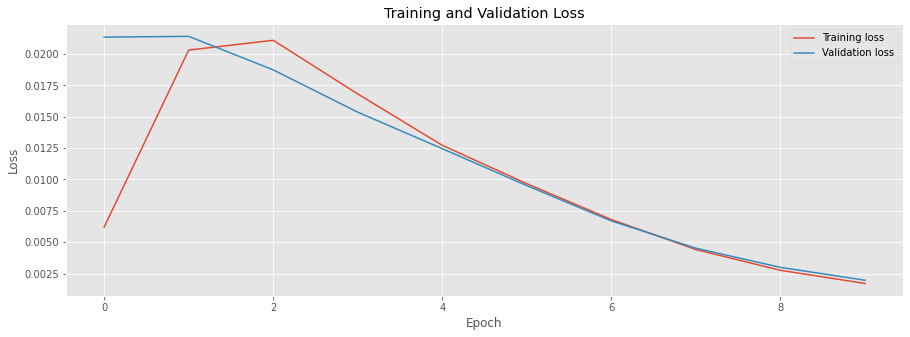

In [280]:
num_epochs=10
if __name__=='__main__':
    train_model(num_epochs)